In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

# import sys 
# sys.path.append('../')
#import feature_cleaning as feature_cleaning

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#sklearn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#sklearn other
#import graphviz 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score, roc_auc_score, auc, roc_curve
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence


In [2]:
edu_df = pd.read_csv('edu_df_15.csv')

# split the data, choosing only edu cols
X = edu_df.drop(columns=[ 'Unnamed: 0', 'SERIALNO', 'FOD1P', 'FOD2P','SOCP','MAJ_SOCP','MAJ_SOCP_labels', 
                'MAJ_SOCP_15','FOD1P_labels','FOD2P_labels','SCHL',
                'SCHL_labels','FOD1P_MAJ_labels', 'FOD1P_MAJ'])
y = edu_df.loc[:,'MAJ_SOCP_15']

X.head()

,SCHL_ord,"FOD1P_MAJ__Agriculture, agriculture operations, and related sciences",FOD1P_MAJ__Architecture and related services,"FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies",FOD1P_MAJ__Biological and biomedical sciences,"FOD1P_MAJ__Business, management, marketing, and related support services","FOD1P_MAJ__Communication, journalism, and related programs",FOD1P_MAJ__Communications technologies/technicians and support services,FOD1P_MAJ__Computer and information sciences and support services,FOD1P_MAJ__Construction trades,FOD1P_MAJ__Education,FOD1P_MAJ__Engineering,FOD1P_MAJ__Engineering technologies and engineering-related fields,FOD1P_MAJ__English language and literature/letters,FOD1P_MAJ__Family and consumer sciences/human sciences,"FOD1P_MAJ__Foreign languages, literatures, and linguistics",FOD1P_MAJ__Health professions and related programs,FOD1P_MAJ__History,"FOD1P_MAJ__Homeland security, law enforcement, firefighting and related protective services",FOD1P_MAJ__Legal professions and studies,"FOD1P_MAJ__Liberal arts and sciences, general studies and humanities",FOD1P_MAJ__Library science,FOD1P_MAJ__Mathematics and statistics,FOD1P_MAJ__Mechanic and repair technologies/technicians,"FOD1P_MAJ__Military science, leadership and operational art",FOD1P_MAJ__Multi/interdisciplinary studies,FOD1P_MAJ__Natural resources and conservation,FOD1P_MAJ__No major,"FOD1P_MAJ__Parks, recreation, leisure, and fitness studies",FOD1P_MAJ__Personal and culinary services,FOD1P_MAJ__Philosophy and religious studies,FOD1P_MAJ__Physical sciences,FOD1P_MAJ__Psychology,FOD1P_MAJ__Public administration and social service professions,FOD1P_MAJ__Science technologies/technicians,FOD1P_MAJ__Social sciences,FOD1P_MAJ__Theology and religious vocations,FOD1P_MAJ__Transportation and materials moving,FOD1P_MAJ__Visual and performing arts,FOD1P__Accounting,FOD1P__Actuarial Science,FOD1P__Advertising And Public Relations,FOD1P__Aerospace Engineering,FOD1P__Agricultural Economics,FOD1P__Agriculture Production And Management,FOD1P__Animal Sciences,FOD1P__Anthropology And Archeology,FOD1P__Applied Mathematics,FOD1P__Architectural Engineering,FOD1P__Architecture,FOD1P__Area Ethnic And Civilization Studies,FOD1P__Art And Music Education,FOD1P__Art History And Criticism,FOD1P__Astronomy And Astrophysics,FOD1P__Atmospheric Sciences And Meteorology,FOD1P__Biochemical Sciences,FOD1P__Biological Engineering,FOD1P__Biology,FOD1P__Biomedical Engineering,FOD1P__Botany,FOD1P__Business Economics,FOD1P__Business Management And Administration,FOD1P__Chemical Engineering,FOD1P__Chemistry,FOD1P__Civil Engineering,FOD1P__Clinical Psychology,FOD1P__Cognitive Science And Biopsychology,FOD1P__Commercial Art And Graphic Design,FOD1P__Communication Disorders Sciences And Services,FOD1P__Communication Technologies,FOD1P__Communications,FOD1P__Community And Public Health,FOD1P__Composition And Rhetoric,FOD1P__Computer Administration Management And Security,FOD1P__Computer And Information Systems,FOD1P__Computer Engineering,FOD1P__Computer Networking And Telecommunications,FOD1P__Computer Programming And Data Processing,FOD1P__Computer Science,FOD1P__Construction Services,FOD1P__Cosmetology Services And Culinary Arts,FOD1P__Counseling Psychology,FOD1P__Court Reporting,FOD1P__Criminal Justice And Fire Protection,FOD1P__Criminology,FOD1P__Drama And Theater Arts,FOD1P__Early Childhood Education,FOD1P__Ecology,FOD1P__Economics,FOD1P__Educational Administration And Supervision,FOD1P__Educational Psychology,FOD1P__Electrical Engineering,FOD1P__Electrical Engineering Technology,"FOD1P__Electrical, Mechanical, And Precision Technologies And Production",FOD1P__Elementary Education,FOD1P__Engineering And Industrial Management,FOD1P__Engineering Mechanics Physics And Science,FOD1P__Engineering Technologies,FOD1P__English Language And Literature,FOD1P__Environmental Engineering,FOD1P__Environmental Science,FOD1P__Family And Consumer Sciences,FOD1P__Film Video And Photographic Arts,FOD1P__F

In [7]:


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42)


# model pipelines
#-----------------------------------
#-------------linear
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_l2 = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_sgd = Pipeline([('scl', StandardScaler()),
            ('clf', SGDClassifier(random_state=42))])


#-------------trees
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_rf_scl = Pipeline([('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_gb = Pipeline([('clf', GradientBoostingClassifier(random_state=42))])


#-------------SVM
pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=42))])


#-------------KNN
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

pipe_knn_scl = Pipeline([('scl', StandardScaler()),
            ('clf', KNeighborsClassifier())])

#-----------------------------------

#-------------XGB
pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])
#-----------------------------------


# grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
max_depth = [10,100,1000,10000]
max_depth2 = [10,100,1000]
alpha_range = [.1, .001, .00001, .000001]
gamma_range = [.1, 1, 10]

#-------------linear
grid_params_lr = [{'clf__penalty': ['l1'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear', ],  #,'saga'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}] 

grid_params_lr_l2 = [{'clf__penalty': ['l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],  #, 'sag'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}]

grid_params_sgd = [{'clf__loss': ['hinge', 'log', 'perceptron'],
        'clf__alpha': alpha_range,
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__class_weight': [None, 'balanced']}] 

#-------------trees
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': max_depth,
        'clf__min_samples_split': param_range[1:],
        'clf__class_weight': [None, 'balanced']}]

grid_params_rf = [{'clf__criterion': ['entropy'],
        'clf__min_samples_leaf': [1],
        'clf__max_depth': [1000],
        'clf__min_samples_split': [10],
        'clf__class_weight': [None],
        'clf__n_estimators':[10]}]

#<3
grid_params_gb = [{'clf__loss': ['deviance', 'exponential'],
        'clf__learning_rate': alpha_range,
        'clf__n_estimators': max_depth2,
        'clf__subsample': param_range_fl}]

#-------------SVM
grid_params_svm = [{'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__degree': param_range[1:],
        'clf__gamma': gamma_range,
        'clf__C': gamma_range,
        'clf__class_weight': [None, 'balanced']}]

#-------------KNN
grid_params_knn = [{'clf__n_neighbors': param_range}]

#-------------XGB

grid_params_xgb = [{}]

# #'clf__n_estimators': max_depth2,
#                    'clf__max_depth': max_depth,
#                    'clf__learning_rate':gamma_range

#--------------------------------------------------------------

# Construct grid searches
jobs = -1
verbose = 2

#-------------linear
gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose) 

gs_lr_l2 = GridSearchCV(estimator=pipe_lr_l2,
            param_grid=grid_params_lr_l2,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_sgd = GridSearchCV(estimator=pipe_sgd,
            param_grid=grid_params_sgd,
            scoring='f1_micro',
            cv=10,
            verbose=verbose)


#-------------trees    
gs_dt = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_dt,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf_scl = GridSearchCV(estimator=pipe_rf_scl,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#-------------SVM

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------KNN
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_knn_scl = GridSearchCV(estimator=pipe_knn_scl,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------XGB
gs_xgb = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#---------------------------------------------------------------------

# List of pipelines for ease of iteration
grids = [ gs_xgb]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'xgb'}

# Fit the grid search objects
print('Performing model optimizations...')
best_f1_micro = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs = gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)

    # Best training data f1
    print('Best training f1: %.3f' % gs.best_score_)

    # Predict on test data with best params
    y_pred = gs.predict(X_test)

    #accuracy
    print('test accuracy {}:'.format( accuracy_score(y_test, y_pred)))
    
    #auc
    print('test auc {}:'.format( roc_auc_score(y_test, y_pred)))

    # Test data accuracy of model with best params
    print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))

    # Track best (highest test f1) model
    if f1_score(y_test, y_pred) > best_f1_micro:
        best_f1_micro = f1_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_model_no_feat_sel_extr_occ_15.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: xgb
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.5s remaining:    0.0s


[CV] ................................................. , total=  36.0s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  35.9s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  36.2s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  36.1s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  36.1s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  35.8s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  35.9s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  36.1s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] ................................................. , total=  35.9s
[CV]  ................................................................


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished


[CV] ................................................. , total=  35.8s
Best params: {}
Best training f1: 0.968
test accuracy 0.9669709757988115:
test auc 0.6427957364822662:
Test set f1 score for best params: 0.393 

Classifier with best test set f1: xgb

Saved xgb grid search pipeline to file: best_model_no_feat_sel_extr_occ_15.pkl


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
started around 3pm

1-0.9640853388454156


0.035914661154584415

In [11]:
0.9666264748944966-0.9640853388454156

0.0025411360490810164

In [12]:
0.0025411360490810164/0.035914661154584415

0.07075483848068122

In [4]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) #try micro


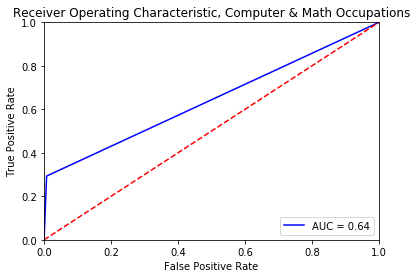

In [5]:
plt.title('Receiver Operating Characteristic, Computer & Math Occupations')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [78]:
model = GradientBoostingClassifier(max_depth=2)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.9682747674590285

In [79]:
model.score(X_test, y_test)

0.966798725346654

In [ ]:
#default train and test xgboost
0.9684039568876421
0.9669709757988115

#default train and test gradientboost
0.9690868152960284
0.9666264748944966

In [80]:
y_pred = model.predict(X_test)
f1_score(y_test, y_pred)

0.3962411902897416

In [119]:
X.columns

Index(['SCHL_ord', 'FOD1P_MAJ__Agriculture, agriculture operations, and related sciences', 'FOD1P_MAJ__Architecture and related services', 'FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies', 'FOD1P_MAJ__Biological and biomedical sciences', 'FOD1P_MAJ__Business, management, marketing, and related support services', 'FOD1P_MAJ__Communication, journalism, and related programs', 'FOD1P_MAJ__Communications technologies/technicians and support services', 'FOD1P_MAJ__Computer and information sciences and support services', 'FOD1P_MAJ__Construction trades',
       ...
       'SCHL__Grade 7', 'SCHL__Grade 8', 'SCHL__Grade 9', 'SCHL__Kindergarten', 'SCHL__Master's degree', 'SCHL__No schooling completed', 'SCHL__Nursery school, preschool', 'SCHL__Professional degree beyond a bachelor's degree', 'SCHL__Regular high school diploma', 'SCHL__Some college, but less than 1 year'], dtype='object', length=388)

In [109]:
featurelist = list(model.feature_importances_)
sortedfeaturelist = sorted(model.feature_importances_)
sortedfeaturelist

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [114]:
featurelist.index(0.0646061517266379)

75

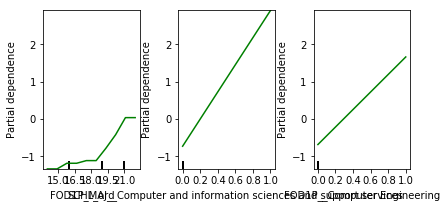

In [120]:
my_plots = plot_partial_dependence(gbrt=model,       
                                   features=[0, 8, 75], # column numbers of plots we want to show
                                   X=X_train,            # raw predictors data.
                                   feature_names=X.columns, # labels on graphs
                                   n_jobs=-1,
                                   grid_resolution=10) # number of values to plot on x axis

''

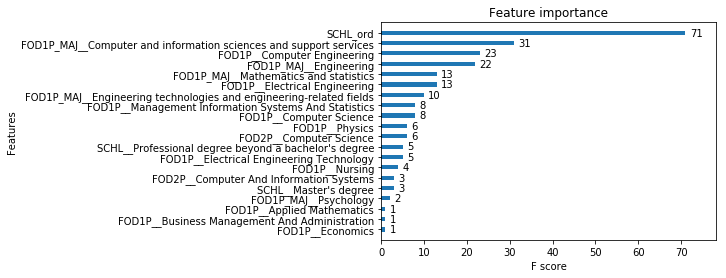

In [71]:
plt.Figure(figsize=(10,30))
xgb.plot_importance(model, grid=False, height=.4)
;